In [27]:

import torch
import os

import datetime
import time

import forest

# from forest.filtering_defenses import get_defense
from forest.utils import write, set_random_seed
from forest.consts import BENCHMARK, NUM_CLASSES
torch.backends.cudnn.benchmark = BENCHMARK

# Parse input arguments
args = forest.options().parse_args()
args.dataset = os.path.join('datasets', args.dataset)
args.exp_name = 'testing'
args.poisonkey = '1-6'
args.attackiter = 250
args.alpha = 0.1
args.trigger = 'sunglasses'
args.devices = '4,5'

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=args.devices

if args.system_seed != None:
    set_random_seed(args.system_seed)

if args.exp_name is None:
    exp_num = len(os.listdir(os.path.join(os.getcwd(), 'outputs'))) + 1
    args.exp_name = f'exp_{exp_num}'

args.output = f'outputs/{args.exp_name}/{args.recipe}/{args.scenario}/{args.trigger}/{args.net[0].upper()}/{args.poisonkey}_{args.scenario}_{args.trigger}_{args.alpha}_{args.beta}_{args.attackoptim}_{args.attackiter}.txt'

os.makedirs(os.path.dirname(args.output), exist_ok=True)
open(args.output, 'w').close() # Clear the output files

torch.cuda.empty_cache()
if args.deterministic:
    forest.utils.set_deterministic()

setup = forest.utils.system_startup(args) # Set up device and torch data type

model = forest.Victim(args, num_classes=NUM_CLASSES, setup=setup) # Initialize model and loss_fn
data = forest.Kettle(args, model.defs.batch_size, model.defs.augmentations,
                        model.defs.mixing_method, setup=setup) # Set up trainloader, validloader, poisonloader, poison_ids, trainset/poisonset/source_testset
witch = forest.Witch(args, setup=setup)

start_time = time.time()
if args.skip_clean_training:
    write('Skipping clean training...', args.output)
else:
    model.train(data, max_epoch=10)
    
# train_time = time.time()
# print("Train time: ", str(datetime.timedelta(seconds=train_time - start_time)))

# if args.recipe != 'naive' and witch.args.backdoor_finetuning:
#     witch.backdoor_finetuning(model, data, lr=0.000005, num_epoch=25)
#     if witch.args.load_feature_repr:
#         model.save_feature_representation()
            
# # Select poisons based on maximum gradient norm
# data.select_poisons(model)

# # Print data status
# data.print_status()
    
# if args.recipe != 'naive':
#     poison_delta = witch.brew(model, data)
# else:
#     poison_delta = None

# craft_time = time.time()
# model.validate(data, poison_delta, val_max_epoch=40)
# print("Craft time: ", str(datetime.timedelta(seconds=craft_time - train_time)))

Monday, 04. March 2024 02:47PM
------------------ Currently evaluating gradient-matching ------------------
Namespace(EPSILON=1e-07, ablation=1.0, alpha=0.1, atk_succ_threshold=99.0, attack_mode='all2one', attackiter=250, attackoptim='signAdam', backdoor_finetuning=False, batch_size=64, beta=0.0, cache_dataset=False, centreg=0, checkpoints='../../checkpoints/', clean_budget=0.2, clean_grad=False, constrain_perturbation=False, cost_multiplier=2, data_aug='default', dataset='datasets/Facial_recognition_crop_partial', defend_features_only=False, defense='', defense_set='testset', defense_sources=None, defense_steps=None, defense_strength=None, defense_type=None, deterministic=False, devices='4,5', digital_trigger=False, digital_trigger_path='digital_triggers', disable_adaptive_attack=True, dryrun=False, early_stop=True, early_stop_patience=10, early_stop_threshold=99.0, ensemble=1, eps=8, exp_name='testing', f='/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-164010boNdt4KDoLfr.json', 

TypeError: can only concatenate str (not "int") to str

In [2]:
net = model.model
for module_pos, module in net._modules.items():
    print(module_pos, module)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
layer1 Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05,

In [10]:
import copy
import torchvision.transforms.v2 as transforms
from forest.data.datasets import data_transforms
from forest.data import datasets
backdoored_model = copy.deepcopy(net)

class ModifyTarget:
    def __init__(self, y_target):
        self.y_target = y_target

    def __call__(self, y_target):
        return self.y_target
    

def backdoor_finetuning(model, kettle, num_epoch=10, lr=0.0001):
    """Finetuning on triggerset of both target class and source class"""    
    write("\nBegin backdoor finetuning ...", args.output)

    source_class = kettle.poison_setup['source_class'][0]
    target_class = kettle.poison_setup['target_class']
    finetune_idcs = kettle.triggerset_dist[source_class]
        
    dirty_triggerset = copy.deepcopy(kettle.triggerset)
    dirty_triggerset.target_transform = transforms.Compose([ModifyTarget(target_class)])
    
    finetune_set = datasets.Subset(dirty_triggerset, finetune_idcs, transform=copy.deepcopy(data_transforms['train']))
    finetune_loader = torch.utils.data.DataLoader(finetune_set, batch_size=16, shuffle=True, num_workers=3)
    
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=lr*0.01)
    for epoch in range(num_epoch):
        total_loss, total_corrects, totals = 0, 0, 0
        for (data, target, idx) in finetune_loader:
            optimizer.zero_grad()
            data, target = data.to(setup['device']), target.to(setup['device'])
            output = model(data)
            
            predictions = torch.argmax(output.data, dim=1)
            correct_preds = (predictions == target).sum().item()
            
            loss = loss_fn(output, target)
        
            loss.backward()
            
            total_loss += loss.item() * data.shape[0] 
            total_corrects += correct_preds
            totals += data.shape[0]
            
            optimizer.step()
            scheduler.step()
        
        total_loss /= totals
        total_corrects /= totals
        write(f"Epoch {epoch} Loss: {total_loss} | Accuracy: {total_corrects}", args.output)
        if total_loss <= 1e-3: 
            write("\n", args.output)
            break

In [11]:
backdoor_finetuning(backdoored_model, data, num_epoch=10, lr=0.0001)

In [ ]:
source_class = data.poison_setup['source_class'][0]
finetune_idcs = data.triggerset_dist[source_class]

dirty_triggerset = copy.deepcopy(data.triggerset)
for sample in dirty_triggerset:
    img, label, idx = sample

In [20]:
# Dummy input
input = torch.randn(1, 1, 28, 28)
# Target for the sake of backward pass
target = torch.tensor([1], dtype=torch.long)

# Forward pass
output = model(input)

# Compute loss
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)

# Backward pass
loss.backward()

Forward hook called. Module: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
torch.Size([1, 1, 28, 28])
Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 10, 24, 24])


/home/ubuntu/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Backward hook called. Module: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
Grad output shape: torch.Size([1, 10, 24, 24])


In [ ]:
from torch.nn import ReLU
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [21]:
from torchvision import models
pretrained_model = models.alexnet(pretrained=True)
first_layer = list(pretrained_model.features._modules.items())[0][1]

/home/ubuntu/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:09<00:00, 25.8MB/s] 


In [ ]:
import numpy as np
from torch.nn import ReLU
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr
    
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Have a look at issue #11 to check why the above is np.ones and not np.zeros
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        from scipy.ndimage.interpolation import zoom
        cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam

tensor([[1.2029e-08, 1.0000e+00, 2.2964e-09, 5.4544e-09, 6.1537e-09, 6.2036e-09,
         8.2665e-09, 4.7913e-09, 7.3582e-10, 6.0390e-09]], device='cuda:0')


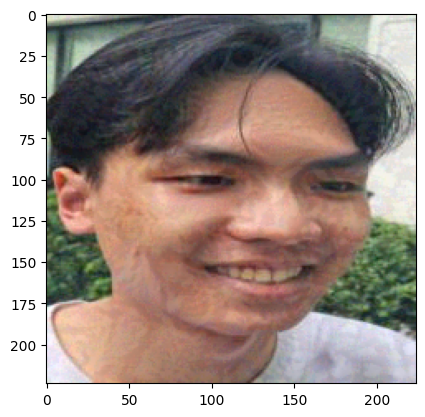

In [10]:
# Check model prediction on poisoned samples
net = model.model
net.eval()
softmax = torch.nn.Softmax(dim=1)

(img, target, idx) = data.poisonset[0]
poison_slice = data.poison_lookup.get(idx)
img_poison = (img + poison_delta[poison_slice]).to(**setup)
with torch.no_grad():
    print(softmax(net(img_poison.unsqueeze(0))))
    
import matplotlib.pyplot as plt
plt.imshow(img_poison.permute(1,2,0).cpu().numpy())

In [11]:
import numpy as np
from scipy.spatial import distance

def cosine_cluster_distances(point, cluster):

    cluster_mean = np.mean(cluster, axis=0)

    # Cosine distance to mean
    distance = 1 - np.dot(point, cluster_mean) / (np.linalg.norm(point) * np.linalg.norm(cluster_mean))
    return distance

In [14]:
from forest.victims.models import bypass_last_layer
featract, classifier = bypass_last_layer(net)

featract.eval()

with torch.no_grad():
    target_class = data.poison_setup['target_class']
    target_class_idcs = data.trainset_distribution[target_class]
    untrigger_target_poi = []
    for idx in target_class_idcs:
        img, _, _ = data.trainset[idx]
        img = img.to(**setup)
        untrigger_target_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())
    
    source_class = data.source_class[0]
    trigger_source_poi = []
    for (img, target, idx) in data.source_testset[source_class]:
        img = img.to(**setup)
        trigger_source_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())
        
    source_class_idcs = data.trainset_distribution[source_class]
    untrigger_source_poi = []
    for idx in source_class_idcs:
        img, _, _ = data.trainset[idx]
        img = img.to(**setup)
        untrigger_source_poi.append(featract(img.unsqueeze(0)).detach().cpu().numpy())

In [15]:
import numpy as np

trigger_source_poi = np.asarray(trigger_source_poi).squeeze()
untrigger_target_poi = np.asarray(untrigger_target_poi).squeeze()
untrigger_source_poi = np.asarray(untrigger_source_poi).squeeze()

In [17]:
with torch.no_grad():
    feat_img_poison = featract(img_poison.unsqueeze(0))

In [18]:
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), trigger_source_poi))
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), untrigger_source_poi))
print(cosine_cluster_distances(feat_img_poison.cpu().numpy(), untrigger_target_poi))

[0.6062993]
[0.6033313]
[0.1708144]
